# Demo Notebook
This notebook demonstrates the use of the `PyOCN` library to create and optimize Optimal Channel Networks (OCNs) on a grid. It includes functions for generating random OCNs, optimizing them using simulated annealing, and visualizing the results.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import multiprocessing

import PyOCN

In [19]:
# initialize an OCN from one of the built-in network types with default parameters
ocn = PyOCN.OCN.from_net_type(
    net_type="H",
    dims=(50, 50),
    random_state=4000,
    verbosity=2
)

# optimize the OCN using simulated annealing and default parameters
energy_history = ocn.fit()

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 50x50 grid.
	Graph is a spanning tree.
	Edges connect only to adjacent nodes).
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.


OCN Optimization: 100%|██████████| 100k/100k [00:00<00:00, 105kit/s, Energy=7.16e+3, T=4.54e-14]  


<Axes: >

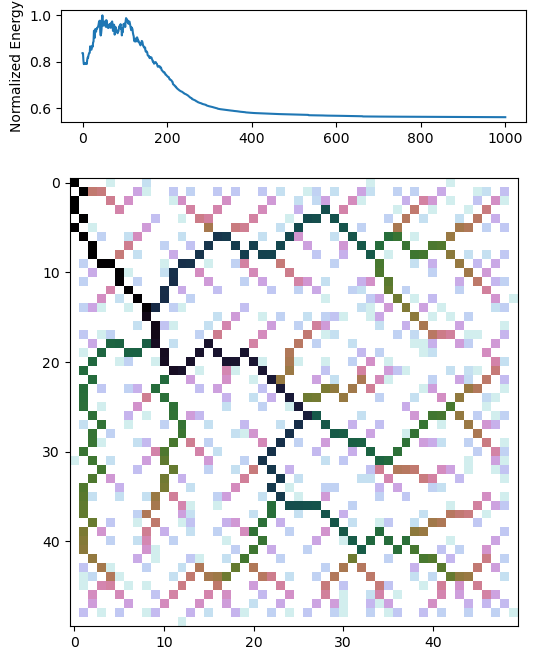

In [20]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(energy_history/np.max(energy_history))
axs[0].set_ylabel("Normalized Energy")

norm = mpl.colors.LogNorm()
PyOCN.plot_ocn_energy_raster(ocn, norm=norm, cmap="cubehelix_r", ax=axs[1])

In [ ]:
m, n = 50, 50
n_iterations = m*n*40

def create_and_run(gamma):
    ocn = PyOCN.OCN.from_net_type(
        "H", 
        dims=(m, n), 
        random_state=8473,
        gamma=gamma,
        verbosity=0
    )
    energy = ocn.fit(
        constant_phase=0.01,
        cooling_rate=0.5, 
        energy_reports=1000, 
        n_iterations=n_iterations, 
        pbar=False
    )
    dag = ocn.to_digraph()
    # Multiprocessing can't pickle ocn objects, which contain pointers to C structs.
    # Instead, return the DAG and reconstruct the OCN later.
    # This would not be necessary if we were running single-threaded.
    return dag, energy  

if __name__ == '__main__':
    gamma_range = [0.1, 0.5, 0.9]
    with multiprocessing.Pool(len(gamma_range)) as pool:
        results = list(pool.map(create_and_run, gamma_range))
    print("Done generating OCNs, plotting...")

    fig, axs = plt.subplots(2, 3, figsize=(15/2, 8/2), height_ratios=[1, 0.25])

    # high gamma
    dag, energy = results[0]
    ocn = PyOCN.OCN.from_digraph(dag)  # Reconstruct OCN from DAG.
    PyOCN.plot_ocn_energy_raster(ocn=ocn, norm=mpl.colors.LogNorm(), ax=axs[0,0], cmap="cubehelix_r")
    axs[1, 0].plot(np.linspace(0, n_iterations, len(energy)), energy/energy.max())


    # middling gamma
    dag, energy = results[1]
    ocn = PyOCN.OCN.from_digraph(dag)
    PyOCN.plot_ocn_energy_raster(ocn=ocn, norm=mpl.colors.LogNorm(), ax=axs[0,1], cmap="cubehelix_r")
    axs[1, 1].plot(np.linspace(0, n_iterations, len(energy)), energy/energy.max())

    # low gamma
    dag, energy = results[2]
    ocn = PyOCN.OCN.from_digraph(dag)
    PyOCN.plot_ocn_energy_raster(ocn=ocn, norm=mpl.colors.LogNorm(), ax=axs[0,2], cmap="cubehelix_r")
    axs[1, 2].plot(np.linspace(0, n_iterations, len(energy)), energy/energy.max())

    fig.tight_layout(h_pad=0.5)

    for ax, gamma in zip(axs[0], gamma_range):
        ax.set_axis_off()
        ax.set_title(f"Gamma = {gamma:.2f}")


    for ax, gamma in zip(axs[1], gamma_range):
        ax.set_ylim(0, 1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Normalized Energy")

        xticks = ax.get_xticks()
        ax.set_xticks(xticks, labels=[f"{int(x/1000)}k" for x in xticks])
        ax.set_xlim(0, n_iterations)

    plt.show()